## Import Required Libraries

In [1]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Define Analysis Function

This function loads the diffraction data, calculates density metrics, and visualizes the results.

In [2]:
def analyze_diffraction_data(filename):
    # Load the file
    s = hs.load(filename)
    
    print(f"Data dimensions: {s.data.shape}")
    print(f"Signal type: {s}")
    
    # For diffraction patterns in a map, we expect a 4D dataset
    # with dimensions: (y, x, diffraction_y, diffraction_x)
    
    # Calculate density metric from diffraction patterns
    # For amorphous materials, we can use the first moment of intensity
    # as a density metric
    
    # Create a radial profile for each diffraction pattern
    # First create radial array
    y, x = np.indices(s.data.shape[2:])
    center = np.array([(y.max() - y.min()) / 2.0, (x.max() - x.min()) / 2.0])
    r = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    r = r.astype(int)
    
    # Initialize density map
    density_map = np.zeros(s.data.shape[:2])
    
    # Calculate a density metric for each position in the map
    for i in range(s.data.shape[0]):
        for j in range(s.data.shape[1]):
            # Get diffraction pattern at this position
            dp = s.data[i, j]
            
            # Calculate radial profile
            r_profile = np.bincount(r.ravel(), dp.ravel())
            
            # Normalize by number of pixels
            r_norm = np.bincount(r.ravel())
            r_profile = r_profile / r_norm
            
            # Calculate first moment (center of mass) of the radial profile
            # This shifts to higher values with higher density in amorphous materials
            r_indices = np.arange(len(r_profile))
            first_moment = np.sum(r_profile * r_indices) / np.sum(r_profile)
            
            # Store in density map
            density_map[i, j] = first_moment
    
    return density_map, s

## Load and Process Data

Specify the path to your .blo file and run the analysis.

In [3]:
# Replace with your .blo file path
filename = "G:/Analytik/Personal/Vivek/PC_Titan_EMPA/PED/20250317_PED_PJ3049_NI01/PJ3049_1645.blo"
density_map, signal = analyze_diffraction_data(filename)

WARNING | Hyperspy | `signal_type='diffraction'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:745)
Data dimensions: (330, 330, 144, 144)
Signal type: <Signal2D, title: , dimensions: (330, 330|144, 144)>


## Visualize Density Map

Create a color-coded density map showing the spatial variation in material density.

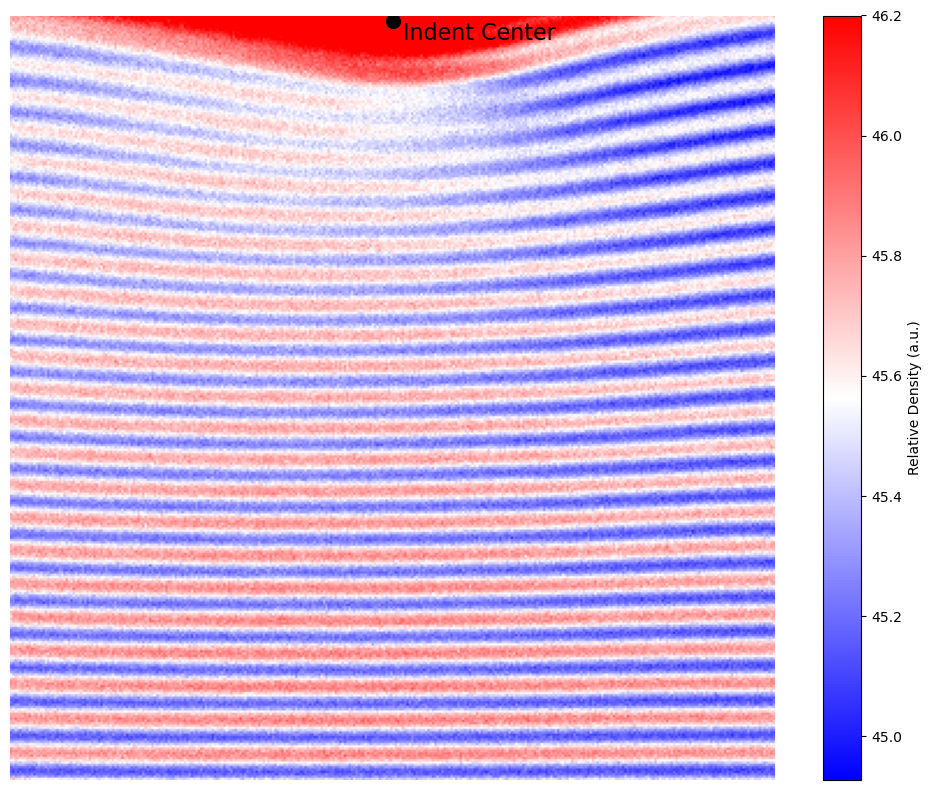

In [17]:
# Plot the density map
plt.figure(figsize=(10, 8))

# Create a custom colormap for density visualization
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
cmap_name = 'density_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

plt.imshow(density_map, cmap=cm)
plt.colorbar(label='Relative Density (a.u.)')
#plt.title('Density Map from Diffraction Patterns')
plt.xlabel('X position (pixels)')
plt.ylabel('Y position (pixels)')

# Annotate the indentation center (assuming it's roughly at the center of the map)
center_y, center_x = np.array(density_map.shape) // 2
plt.plot(center_x, 2, 'o', color='black', markersize=10)
plt.gca().images[0].set_clim(vmax=46.2)  # Adjust color limits for better contrast
plt.annotate('Indent Center', (center_x + 4, 10), color='black', fontsize=16, weight='normal')    
plt.axis('off')
plt.tight_layout()
plt.savefig('G:/Analytik/Personal/Vivek/PC_Titan_EMPA/PED/20250317_PED_PJ3049_NI01/density_map_40nm.png', dpi=300)
plt.show()

## Line Profiles Through Indent Center

Extract and plot horizontal and vertical density profiles through the indentation center.

Pixel size: 3.0 nm


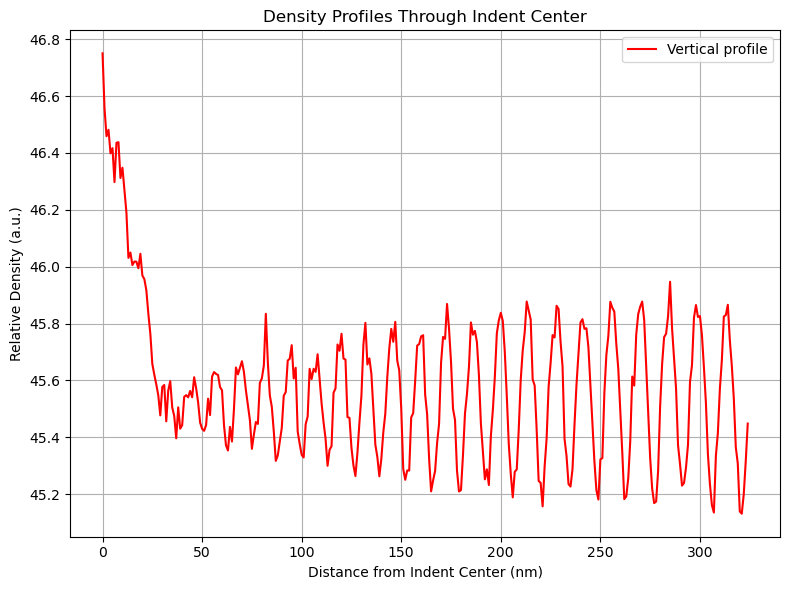

In [23]:
plt.figure(figsize=(8, 6))
center_y, center_x = np.array(density_map.shape) // 2
#plt.plot(density_map[center_y, :], 'b-', label='Horizontal profile')
plt.plot(density_map[5:, center_x], 'r-', label='Vertical profile')
# Check pixel size from metadata
pixel_size = signal.axes_manager[0].scale  # in nm
print(f"Pixel size: {pixel_size} nm")

# Convert x-axis to nm
x_positions = np.arange(len(density_map[5:, center_x])) * pixel_size

plt.xlabel('Distance from Indent Center (nm)')
plt.ylabel('Relative Density (a.u.)')
plt.title('Density Profiles Through Indent Center')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('G:/Analytik/Personal/Vivek/PC_Titan_EMPA/PED/20250317_PED_PJ3049_NI01/density_profiles_40nm.png', dpi=300)
plt.show()